# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3563520/11490434 [========>.....................] - ETA: 0s

 8101888/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:47 - loss: 0.6940

  25/1875 [..............................] - ETA: 3s - loss: 0.5652   

  52/1875 [..............................] - ETA: 3s - loss: 0.4791

  82/1875 [>.............................] - ETA: 3s - loss: 0.4305

 115/1875 [>.............................] - ETA: 3s - loss: 0.3982

 151/1875 [=>............................] - ETA: 2s - loss: 0.3742

 187/1875 [=>............................] - ETA: 2s - loss: 0.3564

 212/1875 [==>...........................] - ETA: 2s - loss: 0.3463

 242/1875 [==>...........................] - ETA: 2s - loss: 0.3358

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3281

 285/1875 [===>..........................] - ETA: 2s - loss: 0.3231

 307/1875 [===>..........................] - ETA: 2s - loss: 0.3174

 333/1875 [====>.........................] - ETA: 2s - loss: 0.3113

 359/1875 [====>.........................] - ETA: 2s - loss: 0.3057

 384/1875 [=====>........................] - ETA: 2s - loss: 0.3007

 406/1875 [=====>........................] - ETA: 2s - loss: 0.2967

 434/1875 [=====>........................] - ETA: 2s - loss: 0.2919

 450/1875 [======>.......................] - ETA: 2s - loss: 0.2893

 468/1875 [======>.......................] - ETA: 2s - loss: 0.2866

 489/1875 [======>.......................] - ETA: 2s - loss: 0.2835

 511/1875 [=======>......................] - ETA: 2s - loss: 0.2804

 541/1875 [=======>......................] - ETA: 2s - loss: 0.2765

 568/1875 [========>.....................] - ETA: 2s - loss: 0.2732

 597/1875 [========>.....................] - ETA: 2s - loss: 0.2698

 624/1875 [========>.....................] - ETA: 2s - loss: 0.2669

 651/1875 [=========>....................] - ETA: 2s - loss: 0.2641

 681/1875 [=========>....................] - ETA: 2s - loss: 0.2612

 715/1875 [==========>...................] - ETA: 2s - loss: 0.2580

 751/1875 [===========>..................] - ETA: 2s - loss: 0.2548

 787/1875 [===========>..................] - ETA: 2s - loss: 0.2519

 807/1875 [===========>..................] - ETA: 2s - loss: 0.2503

 838/1875 [============>.................] - ETA: 1s - loss: 0.2479

 875/1875 [=============>................] - ETA: 1s - loss: 0.2452

 905/1875 [=============>................] - ETA: 1s - loss: 0.2431

 941/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 973/1875 [==============>...............] - ETA: 1s - loss: 0.2387

1003/1875 [===============>..............] - ETA: 1s - loss: 0.2369

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2347

1074/1875 [================>.............] - ETA: 1s - loss: 0.2328

1101/1875 [================>.............] - ETA: 1s - loss: 0.2313

1134/1875 [=================>............] - ETA: 1s - loss: 0.2296

1162/1875 [=================>............] - ETA: 1s - loss: 0.2281

1198/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1227/1875 [==================>...........] - ETA: 1s - loss: 0.2250

1255/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1284/1875 [===================>..........] - ETA: 1s - loss: 0.2224

1314/1875 [====================>.........] - ETA: 1s - loss: 0.2211

1343/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2188

1388/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2171

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2163

1446/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1470/1875 [======================>.......] - ETA: 0s - loss: 0.2148

1492/1875 [======================>.......] - ETA: 0s - loss: 0.2139

1517/1875 [=======================>......] - ETA: 0s - loss: 0.2130

1544/1875 [=======================>......] - ETA: 0s - loss: 0.2121

1573/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1599/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1618/1875 [========================>.....] - ETA: 0s - loss: 0.2095

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1676/1875 [=========================>....] - ETA: 0s - loss: 0.2076

1703/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1731/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1760/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1788/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1816/1875 [============================>.] - ETA: 0s - loss: 0.2033

1844/1875 [============================>.] - ETA: 0s - loss: 0.2025

1872/1875 [============================>.] - ETA: 0s - loss: 0.2018

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2016


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1033

  29/1875 [..............................] - ETA: 3s - loss: 0.1094

  56/1875 [..............................] - ETA: 3s - loss: 0.1096

  84/1875 [>.............................] - ETA: 3s - loss: 0.1098

 109/1875 [>.............................] - ETA: 3s - loss: 0.1098

 138/1875 [=>............................] - ETA: 3s - loss: 0.1098

 166/1875 [=>............................] - ETA: 3s - loss: 0.1098

 194/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 251/1875 [===>..........................] - ETA: 2s - loss: 0.1096

 279/1875 [===>..........................] - ETA: 2s - loss: 0.1096

 307/1875 [===>..........................] - ETA: 2s - loss: 0.1095

 335/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 363/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 391/1875 [=====>........................] - ETA: 2s - loss: 0.1093

 418/1875 [=====>........................] - ETA: 2s - loss: 0.1092

 446/1875 [======>.......................] - ETA: 2s - loss: 0.1092

 478/1875 [======>.......................] - ETA: 2s - loss: 0.1091

 496/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 518/1875 [=======>......................] - ETA: 2s - loss: 0.1090

 540/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1089

 591/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 609/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 637/1875 [=========>....................] - ETA: 2s - loss: 0.1087

 659/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 688/1875 [==========>...................] - ETA: 2s - loss: 0.1086

 709/1875 [==========>...................] - ETA: 2s - loss: 0.1085

 739/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 761/1875 [===========>..................] - ETA: 2s - loss: 0.1084

 785/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 811/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 840/1875 [============>.................] - ETA: 2s - loss: 0.1082

 867/1875 [============>.................] - ETA: 1s - loss: 0.1081

 896/1875 [=============>................] - ETA: 1s - loss: 0.1080

 925/1875 [=============>................] - ETA: 1s - loss: 0.1080

 955/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 982/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1010/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1030/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1055/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1077/1875 [================>.............] - ETA: 1s - loss: 0.1076

1100/1875 [================>.............] - ETA: 1s - loss: 0.1076

1117/1875 [================>.............] - ETA: 1s - loss: 0.1075

1141/1875 [=================>............] - ETA: 1s - loss: 0.1075

1159/1875 [=================>............] - ETA: 1s - loss: 0.1074

1179/1875 [=================>............] - ETA: 1s - loss: 0.1074

1199/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1225/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1252/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1277/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1302/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1325/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1345/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1371/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1396/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1422/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1445/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1474/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1525/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1581/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1609/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1633/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1662/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1684/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1712/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1740/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1764/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1793/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1821/1875 [============================>.] - ETA: 0s - loss: 0.1061

1851/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0962

  26/1875 [..............................] - ETA: 3s - loss: 0.0950

  56/1875 [..............................] - ETA: 3s - loss: 0.0961

  86/1875 [>.............................] - ETA: 3s - loss: 0.0967

 115/1875 [>.............................] - ETA: 3s - loss: 0.0970

 145/1875 [=>............................] - ETA: 3s - loss: 0.0973

 175/1875 [=>............................] - ETA: 2s - loss: 0.0974

 201/1875 [==>...........................] - ETA: 2s - loss: 0.0975

 229/1875 [==>...........................] - ETA: 2s - loss: 0.0975

 259/1875 [===>..........................] - ETA: 2s - loss: 0.0975

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0977

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0977

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0977

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 693/1875 [==========>...................] - ETA: 2s - loss: 0.0978

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0978

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 776/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 806/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 832/1875 [============>.................] - ETA: 1s - loss: 0.0978

 854/1875 [============>.................] - ETA: 1s - loss: 0.0978

 882/1875 [=============>................] - ETA: 1s - loss: 0.0978

 907/1875 [=============>................] - ETA: 1s - loss: 0.0978

 936/1875 [=============>................] - ETA: 1s - loss: 0.0978

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1081/1875 [================>.............] - ETA: 1s - loss: 0.0977

1110/1875 [================>.............] - ETA: 1s - loss: 0.0977

1139/1875 [=================>............] - ETA: 1s - loss: 0.0977

1166/1875 [=================>............] - ETA: 1s - loss: 0.0977

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1825/1875 [============================>.] - ETA: 0s - loss: 0.0976

1852/1875 [============================>.] - ETA: 0s - loss: 0.0975

1875/1875 [==============================] - ETA: 0s - loss: 0.0975

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0975


Epoch 4/5
   1/1875 [..............................] - ETA: 6s - loss: 0.1048

  28/1875 [..............................] - ETA: 3s - loss: 0.0971

  53/1875 [..............................] - ETA: 3s - loss: 0.0967

  78/1875 [>.............................] - ETA: 3s - loss: 0.0965

 106/1875 [>.............................] - ETA: 3s - loss: 0.0964

 129/1875 [=>............................] - ETA: 3s - loss: 0.0963

 155/1875 [=>............................] - ETA: 3s - loss: 0.0962

 177/1875 [=>............................] - ETA: 3s - loss: 0.0962

 203/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 233/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 260/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 288/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 308/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 334/1875 [====>.........................] - ETA: 3s - loss: 0.0960

 357/1875 [====>.........................] - ETA: 3s - loss: 0.0960

 381/1875 [=====>........................] - ETA: 3s - loss: 0.0960

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 466/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 832/1875 [============>.................] - ETA: 2s - loss: 0.0959

 860/1875 [============>.................] - ETA: 1s - loss: 0.0959

 884/1875 [=============>................] - ETA: 1s - loss: 0.0959

 903/1875 [=============>................] - ETA: 1s - loss: 0.0959

 930/1875 [=============>................] - ETA: 1s - loss: 0.0959

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1075/1875 [================>.............] - ETA: 1s - loss: 0.0959

1101/1875 [================>.............] - ETA: 1s - loss: 0.0959

1126/1875 [=================>............] - ETA: 1s - loss: 0.0959

1153/1875 [=================>............] - ETA: 1s - loss: 0.0959

1177/1875 [=================>............] - ETA: 1s - loss: 0.0959

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1361/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1414/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1816/1875 [============================>.] - ETA: 0s - loss: 0.0958

1846/1875 [============================>.] - ETA: 0s - loss: 0.0958

1872/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1013

  31/1875 [..............................] - ETA: 3s - loss: 0.0949

  59/1875 [..............................] - ETA: 3s - loss: 0.0951

  89/1875 [>.............................] - ETA: 3s - loss: 0.0951

 111/1875 [>.............................] - ETA: 3s - loss: 0.0952

 135/1875 [=>............................] - ETA: 3s - loss: 0.0952

 158/1875 [=>............................] - ETA: 3s - loss: 0.0952

 184/1875 [=>............................] - ETA: 3s - loss: 0.0952

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 283/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 308/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 333/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 363/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 686/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 770/1875 [===========>..................] - ETA: 2s - loss: 0.0952

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 821/1875 [============>.................] - ETA: 1s - loss: 0.0952

 851/1875 [============>.................] - ETA: 1s - loss: 0.0952

 879/1875 [=============>................] - ETA: 1s - loss: 0.0952

 908/1875 [=============>................] - ETA: 1s - loss: 0.0952

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1068/1875 [================>.............] - ETA: 1s - loss: 0.0952

1096/1875 [================>.............] - ETA: 1s - loss: 0.0952

1125/1875 [=================>............] - ETA: 1s - loss: 0.0952

1155/1875 [=================>............] - ETA: 1s - loss: 0.0952

1185/1875 [=================>............] - ETA: 1s - loss: 0.0952

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1274/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1819/1875 [============================>.] - ETA: 0s - loss: 0.0951

1849/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

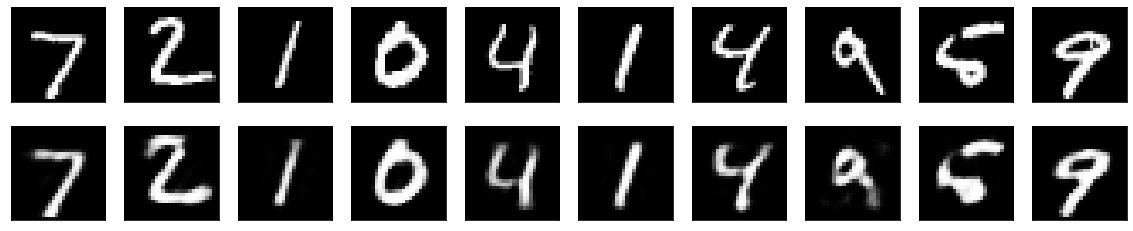

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
